# Hyper

A script to detect the most hyped (popular) bands of a festival

In [1]:
# https://www.dataquest.io/blog/python-pandas-databases/

In [22]:
import sqlite3
import pandas as pd
import string
import unicodedata

## Load Data

In [187]:
# Setup sqlite
sqlite_file = 'hyper.db'

# Connect to the database sqlite file
connection = sqlite3.connect(sqlite_file)
db = connection.cursor()

In [206]:
# get list of bands from db
bands = pd.read_sql_query("SELECT * FROM Bands;", connection)
bands.head()

,id,name,codedName,twitterName
0,1,Arcade Fire,arcadefire,@arcadefire
1,2,Bon Iver,boniver,@boniver
2,3,Mishima,mishima,@mishima
3,4,!!!,!!!,@chkchkchk
4,5,Anímic,animic,@animic


In [207]:
# read tweets from db
tweets = pd.read_sql_query("SELECT * FROM TweetsRaw limit 100;", connection)
tweets.head()
#tweets.describe()

,id,tweetId,createdAt,storedAt,tweetText,favsCount,rtsCount,language,userId,userFriendsCount,userFollowersCount,userStatusesCount,userFavsCount,userLocation
0,1,0,Fri Apr 28 18:36:13 +0200 2017,Mon May 01 19:01:13 +0200 2017,quam nihil molestiae consequatur 6 t laboris...,92,47,la,287,2,482,2625,3550,Barcelona
1,2,0,Wed Apr 26 10:39:13 +0200 2017,Mon May 01 19:01:13 +0200 2017,quam nihil molestiae consequatur h f b labore ...,58,4,la,881,5,880,3293,5663,Barcelona
2,3,0,Mon Apr 24 20:13:13 +0200 2017,Mon May 01 19:01:13 +0200 2017,ea commodi consequatur? V > h quaerat voluptat...,12,80,la,519,10,184,3071,2103,Barcelona
3,4,0,Thu Apr 27 21:01:13 +0200 2017,Mon May 01 19:01:13 +0200 2017,"quis nostrum exercitationem ullam corporis , >...",74,45,la,606,3,226,1792,4859,Barcelona
4,5,0,Tue Apr 25 02:02:13 +0200 2017,Mon May 01 19:01:13 +0200 2017,Excepteur sint occaecat cupidatat ) # r ipsum ...,74,100,la,139,1,184,6408,875,Barcelona


## Partition per band

Look for tweets talking about bands and re-create data structure in a band-centered way

In [191]:
def extract_bands(tweet):
    """
    Function that extracts the bands from a tweet text
    Returns a list of bands
    """
    
    # init list to return
    bands_in_tweet = []
    
    # loop all bands and check of any of the written forms is present in the tweet text
    for i, b in bands.iterrows():
                
        # set different band names writing possibilities
        bandname = b['name']
        bandname_lowercase = bandname.lower()
        bandname_lowercase_no_spaces = ''.join(bandname_lowercase.split())
        bandname_lowercase_no_accents = ''.join((c for c in unicodedata.normalize('NFD', bandname_lowercase) if unicodedata.category(c) != 'Mn'))
        bandname_lowercase_no_spaces_no_accents = ''.join((c for c in unicodedata.normalize('NFD', bandname_lowercase_no_spaces) if unicodedata.category(c) != 'Mn'))

        # check if any of the forms is in the tweet text
        if any(s in tweet['tweetText'].lower() for s in [bandname_lowercase, bandname_lowercase_no_spaces, bandname_lowercase_no_accents, bandname_lowercase_no_spaces_no_accents, b['twitterName']]):
            bands_in_tweet.append({"id": b['id'], "codedName": b['codedName']})

    return bands_in_tweet

In [208]:
# extract bands for each tweet
tweets['bands'] = tweets.apply(extract_bands, axis=1)

In [193]:
def band_partition(tweet):
    """
    Function that reads a single tweet info and adds into a list the tweet information partitioned by bands.
    I.e. If a tweet mentions 2 bands, it adds a list of 2 dicts with the tweet info
    """

    # loop all bands and add an entry to the list
    for b in tweet['bands']:
        band_tweets_list.append({\
                                 "tweetRawId" : tweet['id'],\
                                 "createdAt" : tweet['createdAt'],\
                                 "storedAt" : tweet['storedAt'],\
                                 "bandId" : b['id'],\
                                 "bandCodedName" : b['codedName'],\
                                 "favsCount" : tweet['favsCount'],\
                                 "rtsCount" : tweet['rtsCount'],\
                                 "language" : tweet['language'],\
                                 "userId" : tweet['userId'],\
                                 "userFriendsCount" : tweet['userFriendsCount'],\
                                 "userFollowersCount" : tweet['userFollowersCount'],\
                                 "userStatusesCount" : tweet['userStatusesCount'],\
                                 "userFavsCount" : tweet['userFavsCount'],\
                                 "userLocation" : tweet['userLocation']\
                                })

In [209]:
# construct the list of tweets per band
band_tweets_list = []
tweets.apply(band_partition, axis=1);

# create a dataframe from the previous list
band_tweets = pd.DataFrame.from_dict(band_tweets_list)
band_tweets.head()

,bandCodedName,bandId,createdAt,favsCount,language,rtsCount,storedAt,tweetRawId,userFavsCount,userFollowersCount,userFriendsCount,userId,userLocation,userStatusesCount
0,mishima,3,Fri Apr 28 18:36:13 +0200 2017,92,la,47,Mon May 01 19:01:13 +0200 2017,1,3550,482,2,287,Barcelona,2625
1,animic,5,Fri Apr 28 18:36:13 +0200 2017,92,la,47,Mon May 01 19:01:13 +0200 2017,1,3550,482,2,287,Barcelona,2625
2,boniver,2,Wed Apr 26 10:39:13 +0200 2017,58,la,4,Mon May 01 19:01:13 +0200 2017,2,5663,880,5,881,Barcelona,3293
3,mishima,3,Wed Apr 26 10:39:13 +0200 2017,58,la,4,Mon May 01 19:01:13 +0200 2017,2,5663,880,5,881,Barcelona,3293
4,mishima,3,Mon Apr 24 20:13:13 +0200 2017,12,la,80,Mon May 01 19:01:13 +0200 2017,3,2103,184,10,519,Barcelona,3071


## Explore Tweet Data

In [216]:
# Count tweets per band (manual)
print("Tweets about mishima:     {}".format(band_tweets[band_tweets['bandCodedName'] == "mishima"].shape[0]))
print("Tweets about arcade fire: {}".format(band_tweets[band_tweets['bandCodedName'] == "arcadefire"].shape[0]))
print("Tweets about bon iver:    {}".format(band_tweets[band_tweets['bandCodedName'] == "boniver"].shape[0]))
print("Tweets about animic:      {}".format(band_tweets[band_tweets['bandCodedName'] == "animic"].shape[0]))
print("Tweets about !!!:         {}".format(band_tweets[band_tweets['bandCodedName'] == "!!!"].shape[0]))

Tweets about mishima:     26
Tweets about arcade fire: 16
Tweets about bon iver:    12
Tweets about animic:      16
Tweets about !!!:         18


In [274]:
# Count tweets per band (auto)
print(band_tweets.groupby('bandCodedName').size())

bandCodedName
!!!           18
animic        16
arcadefire    16
boniver       12
mishima       26
dtype: int64


In [273]:
# Count measures of a band
bandCodedName = 'mishima'
print("Tweets about {}:  {}".format(bandCodedName,band_tweets.groupby('bandCodedName').size()[bandCodedName]))
print("Total Favs of {}: {}".format(bandCodedName,band_tweets.groupby('bandCodedName').sum()['favsCount'][bandCodedName]))
print("Total RTs of {}:  {}".format(bandCodedName,band_tweets.groupby('bandCodedName').sum()['rtsCount'][bandCodedName]))

Tweets about mishima:  26
Total Favs of mishima: 1117
Total RTs of mishima:  1353


In [268]:
band_tweets.columns

Index(['bandCodedName', 'bandId', 'createdAt', 'favsCount', 'language',
       'rtsCount', 'storedAt', 'tweetRawId', 'userFavsCount',
       'userFollowersCount', 'userFriendsCount', 'userId', 'userLocation',
       'userStatusesCount'],
      dtype='object')

In [278]:
# timeline of tweet creations
bandCodedName = 'mishima'
tweet_creations =(band_tweets[band_tweets['bandCodedName'] == bandCodedName])['createdAt']

In [279]:
%matplotlib inline
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

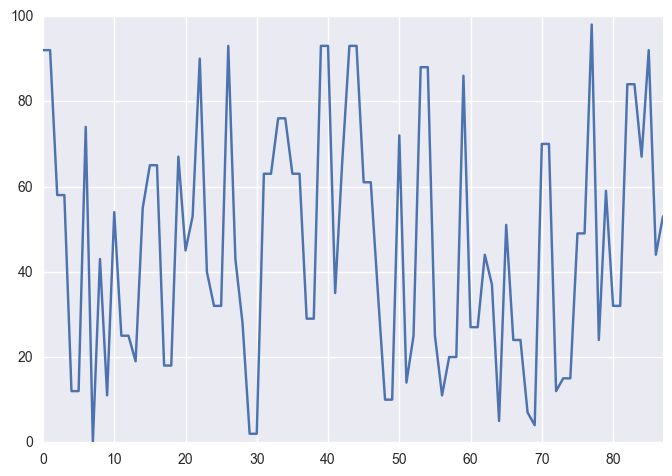

In [287]:
band_tweets['favsCount'].plot()